## Stats and Public Health Part 2
### By Roman Kovalchuk

## Table of Contents:
* [Introduction](#Introduction)
* [Data dictionary](#Data-dictionary)
* [Importing Data](#Importing-Data)
* [Part 1: Basic Analysis](#analysis)
* [Converting WNV Present into a binary column](#binary)
* [Creating dummy variables from trap type column](#dummys)
* [Average number of mosquitoes caught by month](#month)
* [Part 2: Statistical Analysis](#statistical)
* [Using Chi_Square test to observe mosquito species and occurrence of WNV](#chi)
* [Checking correlation with number of mosquitoes caught](#caught)
* [Part 3: Advanced Statistical Analysis](#advanced)
* [Linear Regression](#linear)
* [Preparing for linear regression](#preparing)
* [Verifying assumptions within the model](#verifying)
* [Building a linear regression model](#building)
* [Model diagnostics with residuals and homoscedasticity](#residuals)
* [Logistic Regression](#logistic)
* [Preparing for Logistic Regression](#preparinglog)
* [Building a Logistic Regression model](#buildlog)
* [Model Evaluation and Summary](#eval)
* [Conclusion](#conclusion)

## Introduction<a id="introduction"></a>

In this notebook we will continue our analysis of West Nile Virus (WNV) prevalence in Chicago, Illinois based on a number of traps that are placed in various neighbourhoods around the city. First, we will investigate the difference in average number of mosquitoes caught each month as well as any relationship between WNV prevalence and species of mosquito.  Then we will move on to analysing the relationships between different variables and the mosquito number, as well as the probability of finding WNV at any particular time or location.

## Data dictionary<a id="Data-dictionary"></a>

The dataset contains the following columns:

- Year - Year that the WNV test is performed
- Week - Week that the WNV test is performed
- Address Block	- Address of the location of trap.
- Block	- Block number of address
- Trap - ID of the trap 
- Trap type - Type of trap
- Date - Date and time that the WNV test is performed. 
- Mosquito number - Number of mosquitoes caught in this trap 
- Mosquito ID - Id for Mosquito species
- WNV Present - Whether West Nile Virus was present in these mosquitos
- Species - Mosquito species
- Lat - Latitude of trap
- Lon - Longitude of trap

Notes:
- *Some traps are "satellite traps". These are traps that are set up near (usually within 6 blocks) an established trap to enhance surveillance efforts. Satellite traps are post fixed with letters. For example, T220A is a satellite trap to T220.*

- *Not all the locations are tested at all times. Also, records exist only when a particular species of mosquitoes is found at a certain trap at a certain time.*

- *These test results are organized in such a way that when the number of mosquitoes exceed 50, they are split into another record (another row in the dataset), such that the number of mosquitoes are capped at 50.*	

## Importing Data<a id="importing-data"></a>

Let's import the libraries that we will be working with:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import statsmodels.api as sm
from statsmodels.regression import linear_model 
from scipy import stats
from scipy.stats import norm
from statsmodels.stats.outliers_influence import variance_inflation_factor


Now, let's import our data:

In [2]:
clean_data = pd.read_csv("data/mosquito_data_part_2.csv")


Let's take a look to make sure that everything loaded correctly:

In [3]:
clean_data.head()

,Year,Week,Address Block,Trap,Trap type,Date,Mosquito number,WNV Present,Species,Lat,Lon,Month
0,2019,39,100XX W OHARE AIRPORT,T910,GRAVID,2019-09-26 00:09:00,2,negative,CULEX RESTUANS,41.977738,-87.880969,9
1,2019,39,52XX S KOLMAR AVE,T114,GRAVID,2019-09-26 00:09:00,1,negative,CULEX RESTUANS,41.798211,-87.736925,9
2,2019,39,58XX N WESTERN AVE,T028,GRAVID,2019-09-26 00:09:00,2,negative,CULEX RESTUANS,41.987245,-87.689417,9
3,2019,39,39XX N SPRINGFIELD AVE,T228,GRAVID,2019-09-26 00:09:00,1,negative,CULEX RESTUANS,41.953664,-87.724987,9
4,2019,39,131XX S BRANDON AVE,T209,GRAVID,2019-09-26 00:09:00,9,negative,CULEX RESTUANS,41.657069,-87.546049,9


In [4]:
clean_data.tail()

,Year,Week,Address Block,Trap,Trap type,Date,Mosquito number,WNV Present,Species,Lat,Lon,Month
18490,2016,36,3XX W 18TH ST,T043,GRAVID,2016-09-09 00:09:00,4,positive,CULEX PIPIENS,41.857843,-87.635858,9
18491,2007,34,46XX N MILWAUKEE AVE,T003,GRAVID,2007-08-24 00:08:00,19,positive,CULEX PIPIENS,41.965376,-87.758403,8
18492,2016,30,127XX S DOTY AVE,T115,GRAVID,2016-07-27 00:07:00,34,positive,CULEX RESTUANS,41.662395,-87.590176,7
18493,2017,33,20XX N DOMINICK ST,T240B,SENTINEL,2017-08-17 00:08:00,50,positive,CULEX RESTUANS,41.919197,-87.664758,8
18494,2015,33,100XX W OHARE AIRPORT,T902,GRAVID,2015-08-20 00:08:00,6,positive,CULEX RESTUANS,41.977738,-87.880969,8


In [5]:
clean_data.shape

(18495, 12)

In [6]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18495 entries, 0 to 18494
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Year             18495 non-null  int64  
 1   Week             18495 non-null  int64  
 2   Address Block    18495 non-null  object 
 3   Trap             18495 non-null  object 
 4   Trap type        18495 non-null  object 
 5   Date             18495 non-null  object 
 6   Mosquito number  18495 non-null  int64  
 7   WNV Present      18495 non-null  object 
 8   Species          18495 non-null  object 
 9   Lat              18495 non-null  float64
 10  Lon              18495 non-null  float64
 11  Month            18495 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 1.7+ MB


In [7]:
# Checking for nulls
clean_data.isnull().sum().any()

False

There are no null values present in our data.

In [8]:
# looking at the shape of dataset
print(f'There are {clean_data.shape[0]} rows and {clean_data.shape[1]} columns in the dataset.')

There are 18495 rows and 12 columns in the dataset.


In [9]:
# Summary statistics 
clean_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,18495.0,2012.905812,3.725857,2007.000000,2010.000000,2013.000000,2016.000000,2019.000000
Week,18495.0,31.004001,4.332020,20.000000,28.000000,31.000000,34.000000,40.000000
Mosquito number,18495.0,10.879913,13.475066,1.000000,2.000000,5.000000,14.000000,50.000000
Lat,18495.0,41.852599,0.115419,41.644720,41.754148,41.872873,41.970102,42.017801
Lon,18495.0,-87.712611,0.095409,-87.880969,-87.778235,-87.703105,-87.643076,-87.531051
Month,18495.0,7.627088,0.998079,5.000000,7.000000,8.000000,8.000000,10.000000


In [10]:
clean_data.dtypes

Year                 int64
Week                 int64
Address Block       object
Trap                object
Trap type           object
Date                object
Mosquito number      int64
WNV Present         object
Species             object
Lat                float64
Lon                float64
Month                int64
dtype: object

In [11]:
# Converting the date column into datetime format
clean_data['Date']= pd.to_datetime(clean_data['Date'])

Everything loaded correctly and we're good to go.

## Part 1: Basic Analysis<a id="analysis"></a>

### Converting WNV Present into a binary column<a id="binary"></a>

In [12]:
#Converting `WNV Present` into binary data
df_one = pd.get_dummies(clean_data["WNV Present"])

#Concatenating binary data in to DataFrame
df_two = pd.concat((df_one, clean_data), axis=1)

#Dropping `WNV Present` column
df_two = df_two.drop(["WNV Present"], axis=1)

#Since "positive" = 1 and "negative" = 0, we can drop the "negative" column
df_two = df_two.drop(["negative"], axis=1)

#Now we can rename the column and save it back in to our DataFrame
clean_data = df_two.rename(columns={"positive": "WNV Present"})


Let's make sure that everything worked:

In [13]:
clean_data

,WNV Present,Year,Week,Address Block,Trap,Trap type,Date,Mosquito number,Species,Lat,Lon,Month
0,0,2019,39,100XX W OHARE AIRPORT,T910,GRAVID,2019-09-26 00:09:00,2,CULEX RESTUANS,41.977738,-87.880969,9
1,0,2019,39,52XX S KOLMAR AVE,T114,GRAVID,2019-09-26 00:09:00,1,CULEX RESTUANS,41.798211,-87.736925,9
2,0,2019,39,58XX N WESTERN AVE,T028,GRAVID,2019-09-26 00:09:00,2,CULEX RESTUANS,41.987245,-87.689417,9
3,0,2019,39,39XX N SPRINGFIELD AVE,T228,GRAVID,2019-09-26 00:09:00,1,CULEX RESTUANS,41.953664,-87.724987,9
4,0,2019,39,131XX S BRANDON AVE,T209,GRAVID,2019-09-26 00:09:00,9,CULEX RESTUANS,41.657069,-87.546049,9
...,...,...,...,...,...,...,...,...,...,...,...,...
18490,1,2016,36,3XX W 18TH ST,T043,GRAVID,2016-09-09 00:09:00,4,CULEX PIPIENS,41.857843,-87.635858,9
18491,1,2007,34,46XX N MILWAUKEE AVE,T003,GRAVID,2007-08-24 00:08:00,19,CULEX PIPIENS,41.965376,-87.758403,8
18492,1,2016,30,127XX S DOTY AVE,T115,GRAVID,2016-07-27 00:07:00,34,CULEX RESTUANS,41.662395,-87.590176,7
18493,1,2017,33,20XX N DOMINICK ST,T240B,SENTINEL,2017-08-17 00:08:00,50,CULEX RESTUANS,41.919197,-87.664758,8


Great, we now have a `WNV Present` column with binary values. Negative values are represented as "0" and positives as "1".

### Creating dummy variables from the `Trap type` column<a id="dummys"></a>

Next, let's create dummy variables from the `Trap type` category which represents the 4 types of traps that were used to capture mosquitoes.

In [14]:
dummies = pd.get_dummies(clean_data["Trap type"])

#Concatenating binary data in to DataFrame
clean_data = pd.concat((dummies, clean_data), axis=1)

#dropping Trap type category
clean_data.drop(columns="Trap type", inplace=True)


In [15]:
clean_data.head()

,CDC,GRAVID,OVI,SENTINEL,WNV Present,Year,Week,Address Block,Trap,Date,Mosquito number,Species,Lat,Lon,Month
0,0,1,0,0,0,2019,39,100XX W OHARE AIRPORT,T910,2019-09-26 00:09:00,2,CULEX RESTUANS,41.977738,-87.880969,9
1,0,1,0,0,0,2019,39,52XX S KOLMAR AVE,T114,2019-09-26 00:09:00,1,CULEX RESTUANS,41.798211,-87.736925,9
2,0,1,0,0,0,2019,39,58XX N WESTERN AVE,T028,2019-09-26 00:09:00,2,CULEX RESTUANS,41.987245,-87.689417,9
3,0,1,0,0,0,2019,39,39XX N SPRINGFIELD AVE,T228,2019-09-26 00:09:00,1,CULEX RESTUANS,41.953664,-87.724987,9
4,0,1,0,0,0,2019,39,131XX S BRANDON AVE,T209,2019-09-26 00:09:00,9,CULEX RESTUANS,41.657069,-87.546049,9


Let's check the value counts of each of our dummy variables:

In [16]:
#assigning variables to our dummies in order to check value counts
cdc = clean_data["CDC"].value_counts()
gravid = clean_data["GRAVID"].value_counts()
ovi = clean_data["OVI"].value_counts()
sentinel = clean_data["SENTINEL"].value_counts()

In [17]:
#printing cdc
print(cdc)

#printing gravid
print(gravid)

#printing ovi
print(ovi)

#printing sentinel
print(sentinel)


0    17951
1      544
Name: CDC, dtype: int64
1    17741
0      754
Name: GRAVID, dtype: int64
0    18494
1        1
Name: OVI, dtype: int64
0    18286
1      209
Name: SENTINEL, dtype: int64


In [18]:
#dropping OVI variable to avoid multicollinearity
clean_data.drop(columns=["OVI"])

,CDC,GRAVID,SENTINEL,WNV Present,Year,Week,Address Block,Trap,Date,Mosquito number,Species,Lat,Lon,Month
0,0,1,0,0,2019,39,100XX W OHARE AIRPORT,T910,2019-09-26 00:09:00,2,CULEX RESTUANS,41.977738,-87.880969,9
1,0,1,0,0,2019,39,52XX S KOLMAR AVE,T114,2019-09-26 00:09:00,1,CULEX RESTUANS,41.798211,-87.736925,9
2,0,1,0,0,2019,39,58XX N WESTERN AVE,T028,2019-09-26 00:09:00,2,CULEX RESTUANS,41.987245,-87.689417,9
3,0,1,0,0,2019,39,39XX N SPRINGFIELD AVE,T228,2019-09-26 00:09:00,1,CULEX RESTUANS,41.953664,-87.724987,9
4,0,1,0,0,2019,39,131XX S BRANDON AVE,T209,2019-09-26 00:09:00,9,CULEX RESTUANS,41.657069,-87.546049,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18490,0,1,0,1,2016,36,3XX W 18TH ST,T043,2016-09-09 00:09:00,4,CULEX PIPIENS,41.857843,-87.635858,9
18491,0,1,0,1,2007,34,46XX N MILWAUKEE AVE,T003,2007-08-24 00:08:00,19,CULEX PIPIENS,41.965376,-87.758403,8
18492,0,1,0,1,2016,30,127XX S DOTY AVE,T115,2016-07-27 00:07:00,34,CULEX RESTUANS,41.662395,-87.590176,7
18493,0,0,1,1,2017,33,20XX N DOMINICK ST,T240B,2017-08-17 00:08:00,50,CULEX RESTUANS,41.919197,-87.664758,8


Let's check to make sure that it worked:

In [19]:
#checking data
clean_data.head()

,CDC,GRAVID,OVI,SENTINEL,WNV Present,Year,Week,Address Block,Trap,Date,Mosquito number,Species,Lat,Lon,Month
0,0,1,0,0,0,2019,39,100XX W OHARE AIRPORT,T910,2019-09-26 00:09:00,2,CULEX RESTUANS,41.977738,-87.880969,9
1,0,1,0,0,0,2019,39,52XX S KOLMAR AVE,T114,2019-09-26 00:09:00,1,CULEX RESTUANS,41.798211,-87.736925,9
2,0,1,0,0,0,2019,39,58XX N WESTERN AVE,T028,2019-09-26 00:09:00,2,CULEX RESTUANS,41.987245,-87.689417,9
3,0,1,0,0,0,2019,39,39XX N SPRINGFIELD AVE,T228,2019-09-26 00:09:00,1,CULEX RESTUANS,41.953664,-87.724987,9
4,0,1,0,0,0,2019,39,131XX S BRANDON AVE,T209,2019-09-26 00:09:00,9,CULEX RESTUANS,41.657069,-87.546049,9


### Average number of mosquitoes caught by month<a id="month"></a>

Now let's find the average number of mosquitoes caught each month. First, we can add up the total number of mosquitoes grouped by month and year.

In [20]:
#Finding total number of mosquitoes caught by month each year and saving them to total_month variable
total_month = clean_data.groupby(["Month", "Year"])['Mosquito number'].sum()

Now we can calculate the average number of mosquitoes caught each month:

In [21]:
#calculating the mean number of mosquitoes caught each month
mean_month = total_month.groupby("Month").mean()
mean_month

Month
5       58.000000
6     2200.538462
7     4539.000000
8     6402.230769
9     2235.000000
10     302.500000
Name: Mosquito number, dtype: float64

Let's see the percentage of mosquitoes captured in each month and observe the relationship on a bar graph:

In [22]:
percentage = mean_month / mean_month.sum() *100
percentage

Month
5      0.368552
6     13.982975
7     28.842361
8     40.681968
9     14.201956
10     1.922189
Name: Mosquito number, dtype: float64

We can see that July and August were the top months, as the summer months are when mosquitoes typically breed. Over 68% of mosquitoes were captured in July and August with August having 40% of all values. 

In [23]:
#changing the style of the plot

plt.style.use('ggplot')

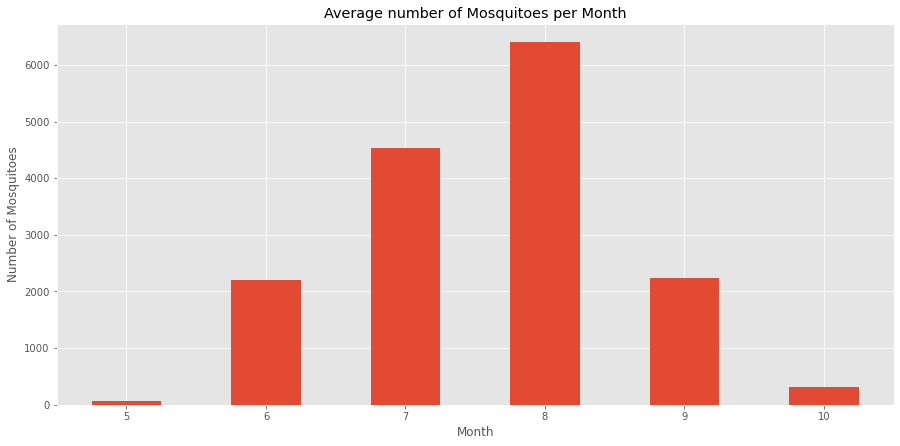

In [24]:
plt.subplots(figsize=(15, 7))

#plotting a bar graph 
mean_month.plot(kind="bar")

#creating title x-axis, y-axis labels and rotating xticks to be more readable
plt.title("Average number of Mosquitoes per Month")
plt.xlabel("Month")
plt.xticks(rotation=1)
plt.ylabel("Number of Mosquitoes")

#showing the plot
plt.show()

From the values above, we can see that the bulk of mosquitoes were captured in the summer, particularly during August.

## Part 2 - Statistical Analysis<a id="statistical"></a>

### Using Chi-Square test to observe mosquito species and occurrence of West Nile<a id="chi"></a>

In order to see whether there is a statistically significant difference between Presence of WNV and mosquito species, we can run a Chi-Square analysis which will give us some insight whether there is an association between them but first, we should set up our null and alternative hypothesis:

$H_0$: There is no difference in WNV prevalence between species in mosquitoes

$H_1$: There is a difference in terms of WNV prevalence in different species of mosquitoes.

Our objective is to run a Chi-Square test, which will help us evaluate whether a difference in observed data and expected data is due to chance or if an actual relationship between the variables exists. This is done with the help of the p-value. If the p-value is lower than 0.05, then we can reject the null hypothesis and assert that a relationship does exist between WNV prevalence and species of mosquitoes. If it is higher than 0.05, then we can not reject the null hypothesis.

In [25]:
# Create a contingency table of the mosquito species and West Nile Virus occurrence
cont_table = pd.crosstab(clean_data['WNV Present'], clean_data['Species'])

# Printing the contingency table
print(cont_table)

Species      CULEX PIPIENS  CULEX RESTUANS  CULEX SALINARIUS  CULEX TERRITANS
WNV Present                                                                  
0                     4074            9309               215              903
1                     1412            2557                11               14


In the above contingency table, we can see WNV Presence broken down by each species of mosquito. The most prominent 

In [26]:
# Use the Chi-Square test of independence to evaluate the association between the variables
stat, p, dof, expected = chi2_contingency(cont_table)

# Print the results
print(f"Chi-Square statistic: {stat}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected values:")
print(expected)

Chi-Square statistic: 311.10394683130164
P-value: 3.9302341764409087e-67
Degrees of freedom: 3
Expected values:
[[4301.29689105 9303.5342525   177.19524196  718.97361449]
 [1184.70310895 2562.4657475    48.80475804  198.02638551]]


### Checking correlation with number of mosquitoes caught<a id="caught"></a>

To determine which columns are positively correlated with number of mosquitoes caught, we can create a correlation matrix and then visualize it with a heatmap:

In [27]:
#defining a correlation matrix
clean_data.corr()

,CDC,GRAVID,OVI,SENTINEL,WNV Present,Year,Week,Mosquito number,Lat,Lon,Month
CDC,1.000000,-0.844420,-0.001280,-0.018611,0.002740,-0.261514,0.028723,0.094147,-0.068795,0.060961,0.070174
GRAVID,-0.844420,1.000000,-0.035669,-0.518582,-0.027359,0.155283,-0.047021,-0.138275,0.067916,-0.081628,-0.078398
OVI,-0.001280,-0.035669,1.000000,-0.000786,-0.003859,-0.011656,-0.013587,-0.005392,0.001292,-0.004017,-0.011988
SENTINEL,-0.018611,-0.518582,-0.000786,1.000000,0.047073,0.128327,0.043002,0.108575,-0.017184,0.055548,0.035333
WNV Present,0.002740,-0.027359,-0.003859,0.047073,1.000000,0.153881,0.174265,0.408034,0.110175,-0.163967,0.161334
Year,-0.261514,0.155283,-0.011656,0.128327,0.153881,1.000000,-0.023283,0.129326,0.093983,-0.094628,-0.100847
Week,0.028723,-0.047021,-0.013587,0.043002,0.174265,-0.023283,1.000000,-0.033900,-0.002876,0.002967,0.948940
Mosquito number,0.094147,-0.138275,-0.005392,0.108575,0.408034,0.129326,-0.033900,1.000000,0.096820,-0.151421,-0.040426
Lat,-0.068795,0.067916,0.001292,-0.017184,0.110175,0.093983,-0.002876,0.096820,1.000000,-0.749416,-0.011544
Lon,0.060961,-0.081628,-0.004017,0.055548,-0.163967,-0.094628,0.002967,-0.151421,-0.749416,1.000000,0.010695


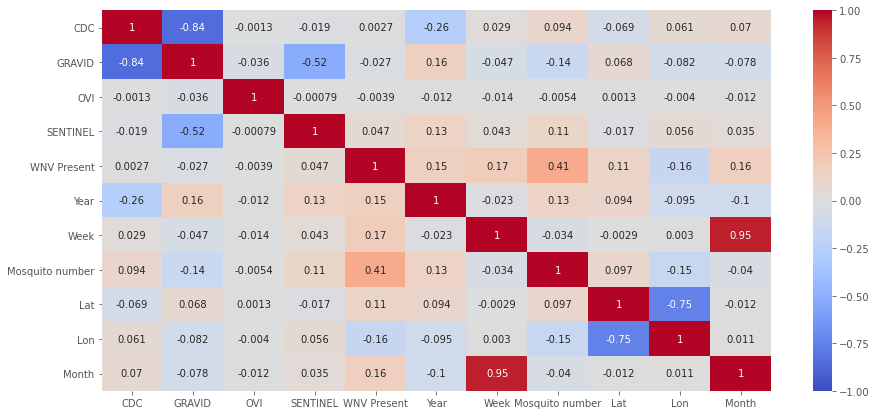

In [28]:
#visualizing the correlations with a heatmap
plt.subplots(figsize=(15, 7))
sns.heatmap(clean_data.corr(), cmap='coolwarm', annot=True, vmin=-1, vmax=1) 
plt.show()

From the table and heatmap above, we can see that `WNV Present`, `SENTINEL`, and `Year` are slightly correlated with number of mosquitoes caught, with `WNV Present` having a 0.41 correlation with the other two at 0.11 and 0.13 respectably. The `CDC` variable has a slight positive correlation of .094 and `Lat`itutude also shows a low positive correlation of .097, but we can discount this since it's a geographical variable. We can run a Chi-Square test to see if there is a significant correlation for these variables. First, let's lay out our hypothesis:

$H_0$: There is no statistical significance between `WNV Present` and `Mosquito number`

$H_1$: There is a relationship between `WNV Present` and `Mosquito number`.

In [29]:
# Creating contingency table for 'Mosquito number' and "WNV Present" categories
cont_table2 = pd.crosstab(clean_data['Mosquito number'], clean_data['WNV Present'])

# Useing the Chi-Square test of independence to evaluate the association between the variables
stat, p, dof, expected = chi2_contingency(cont_table2)

# Print the results
print(f"Chi-Square statistic: {stat}")
print(f"P-value: {p}")

Chi-Square statistic: 3736.2749283927633
P-value: 0.0


The P-value is exactly 0, meaning that there is a statistical significance between `Mosquito number` and the `WNV Present` test and that there is observable presence of West Nile virus in the number of mosquitoes caught. We can safely reject the proposed null hypothesis that there isn't any significance. Our .41 correlation value led us to see this relationship.

Now let's try running the Chi-Square test for the other two positively correlated variables:

In [30]:
# Creating contingency table for 'Mosquito number' and "SENTINEL" categories
cont_table3 = pd.crosstab(clean_data['Mosquito number'], clean_data['SENTINEL'])

# Useing the Chi-Square test of independence to evaluate the association between the variables
stat, p, dof, expected = chi2_contingency(cont_table3)

# Print the results
print(f"Chi-Square statistic: {stat}")
print(f"P-value: {p}")

Chi-Square statistic: 411.9249073841888
P-value: 7.544592354918411e-59


In [31]:
# Creating contingency table for 'Mosquito number' and "Year" categories
cont_table4 = pd.crosstab(clean_data['Mosquito number'], clean_data['Year'])

# Useing the Chi-Square test of independence to evaluate the association between the variables
stat, p, dof, expected = chi2_contingency(cont_table4)

# Print the results
print(f"Chi-Square statistic: {stat}")
print(f"P-value: {p}")

Chi-Square statistic: 4097.090532144765
P-value: 0.0


`Lon` and `Lat` are negatively correlated, as well as two of the trap types, `GRAVID` and `SENTINEL`. This is not surprising as they both hold similar information.  `Year` is also negatively correlated with `CDC` type meaning that it wasn't a popular trap over the years.

## Part 3 - Advanced Statistical Analysis<a id="advanced"></a>

### Linear Regression<a id="linear"></a>

Now we can perform a linear regression with `Mosquito number` as the dependent variable. Linear regression is a statistical method which involves fitting a linear equation to a set of data points, where one variable (known as the dependent variable) is predicted by the other (independent) variable.

It can be used to make predictions about the dependent variable based on the independent variables and to determine the strength and direction of the relationship between the two variables.

### Preparing for Linear Regression<a id="preparing"></a>

Before we begin, let's make a copy of our data frame for the this analysis:

In [32]:
df_linreg = clean_data.copy()
df_linreg.head()

,CDC,GRAVID,OVI,SENTINEL,WNV Present,Year,Week,Address Block,Trap,Date,Mosquito number,Species,Lat,Lon,Month
0,0,1,0,0,0,2019,39,100XX W OHARE AIRPORT,T910,2019-09-26 00:09:00,2,CULEX RESTUANS,41.977738,-87.880969,9
1,0,1,0,0,0,2019,39,52XX S KOLMAR AVE,T114,2019-09-26 00:09:00,1,CULEX RESTUANS,41.798211,-87.736925,9
2,0,1,0,0,0,2019,39,58XX N WESTERN AVE,T028,2019-09-26 00:09:00,2,CULEX RESTUANS,41.987245,-87.689417,9
3,0,1,0,0,0,2019,39,39XX N SPRINGFIELD AVE,T228,2019-09-26 00:09:00,1,CULEX RESTUANS,41.953664,-87.724987,9
4,0,1,0,0,0,2019,39,131XX S BRANDON AVE,T209,2019-09-26 00:09:00,9,CULEX RESTUANS,41.657069,-87.546049,9


Next, let's create dummy variables from our `Species` variable:

In [33]:
dummies2 = pd.get_dummies(df_linreg["Species"])

#Concatenating binary data in to DataFrame
df_linreg = pd.concat((dummies2, clean_data), axis=1)

#dropping Species category
df_linreg.drop(columns="Species", inplace=True)

#dropping CULEX SALINARIUS to avoid multicollinearity
df_linreg.drop(columns=["CULEX SALINARIUS"])

,CULEX PIPIENS,CULEX RESTUANS,CULEX TERRITANS,CDC,GRAVID,OVI,SENTINEL,WNV Present,Year,Week,Address Block,Trap,Date,Mosquito number,Lat,Lon,Month
0,0,1,0,0,1,0,0,0,2019,39,100XX W OHARE AIRPORT,T910,2019-09-26 00:09:00,2,41.977738,-87.880969,9
1,0,1,0,0,1,0,0,0,2019,39,52XX S KOLMAR AVE,T114,2019-09-26 00:09:00,1,41.798211,-87.736925,9
2,0,1,0,0,1,0,0,0,2019,39,58XX N WESTERN AVE,T028,2019-09-26 00:09:00,2,41.987245,-87.689417,9
3,0,1,0,0,1,0,0,0,2019,39,39XX N SPRINGFIELD AVE,T228,2019-09-26 00:09:00,1,41.953664,-87.724987,9
4,0,1,0,0,1,0,0,0,2019,39,131XX S BRANDON AVE,T209,2019-09-26 00:09:00,9,41.657069,-87.546049,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18490,1,0,0,0,1,0,0,1,2016,36,3XX W 18TH ST,T043,2016-09-09 00:09:00,4,41.857843,-87.635858,9
18491,1,0,0,0,1,0,0,1,2007,34,46XX N MILWAUKEE AVE,T003,2007-08-24 00:08:00,19,41.965376,-87.758403,8
18492,0,1,0,0,1,0,0,1,2016,30,127XX S DOTY AVE,T115,2016-07-27 00:07:00,34,41.662395,-87.590176,7
18493,0,1,0,0,0,0,1,1,2017,33,20XX N DOMINICK ST,T240B,2017-08-17 00:08:00,50,41.919197,-87.664758,8


In [34]:
df_linreg.head()

,CULEX PIPIENS,CULEX RESTUANS,CULEX SALINARIUS,CULEX TERRITANS,CDC,GRAVID,OVI,SENTINEL,WNV Present,Year,Week,Address Block,Trap,Date,Mosquito number,Lat,Lon,Month
0,0,1,0,0,0,1,0,0,0,2019,39,100XX W OHARE AIRPORT,T910,2019-09-26 00:09:00,2,41.977738,-87.880969,9
1,0,1,0,0,0,1,0,0,0,2019,39,52XX S KOLMAR AVE,T114,2019-09-26 00:09:00,1,41.798211,-87.736925,9
2,0,1,0,0,0,1,0,0,0,2019,39,58XX N WESTERN AVE,T028,2019-09-26 00:09:00,2,41.987245,-87.689417,9
3,0,1,0,0,0,1,0,0,0,2019,39,39XX N SPRINGFIELD AVE,T228,2019-09-26 00:09:00,1,41.953664,-87.724987,9
4,0,1,0,0,0,1,0,0,0,2019,39,131XX S BRANDON AVE,T209,2019-09-26 00:09:00,9,41.657069,-87.546049,9


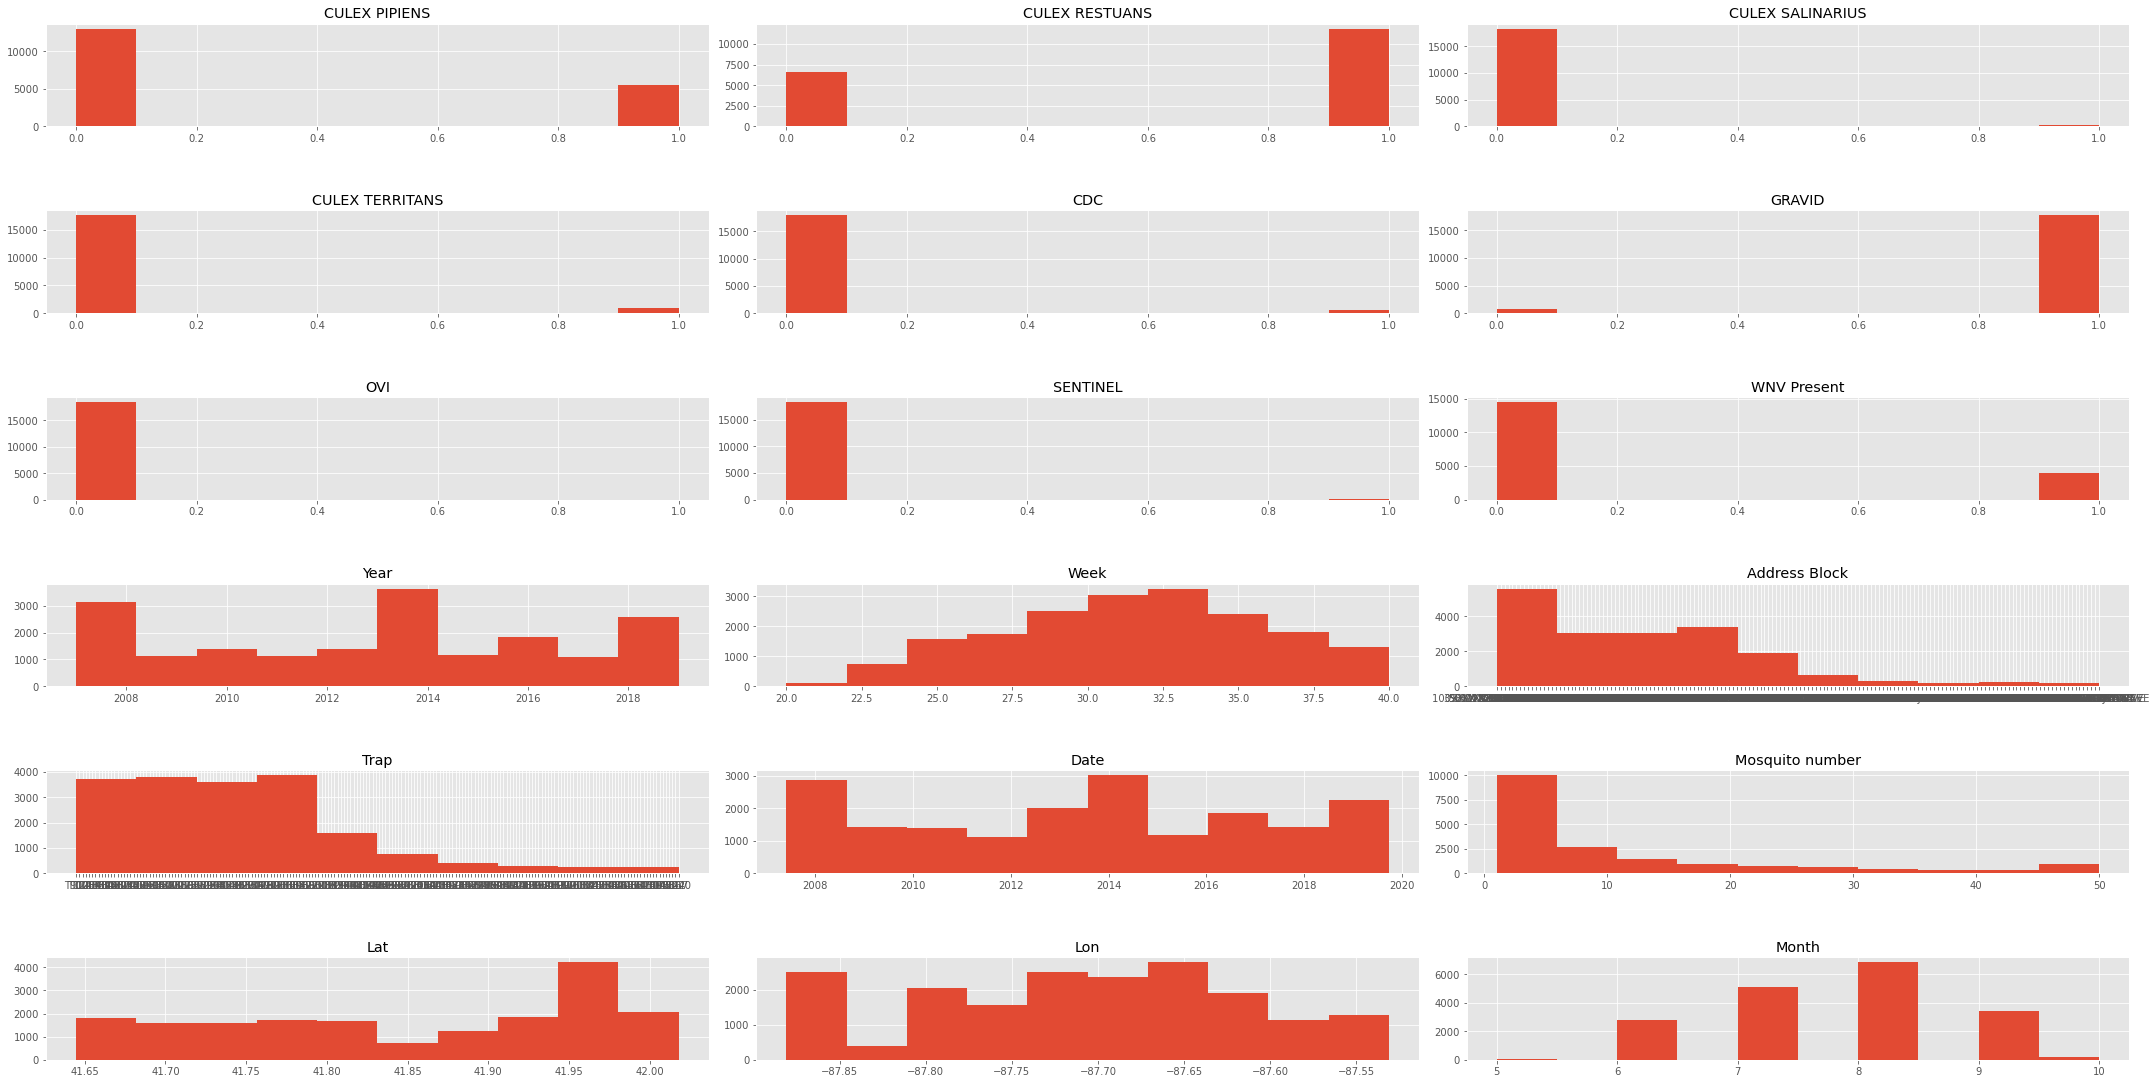

In [35]:
# Lets check out the distributions.

# Setting the plots layout
plt.subplots(6, 3, figsize=(30, 15))

# Plotting
for i, column in enumerate(df_linreg.columns, 1):
    plt.subplot(6, 3, i)
    plt.hist(df_linreg[column])
    plt.title(column)
plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=5.0)

The first 7 columns are binary and contain clear peaks in either column. For example we see that the `GRAVID` trap was most commonly used and that `CULEX RESTUANS` species had a high number of positive WNV cases. The other variables also show peaks, particularly `Year` in the 2014 column as well as the `Lat` and `Lon` values. 

Let's visualize the `Lat` and `Lon` columns on a scatter plot.

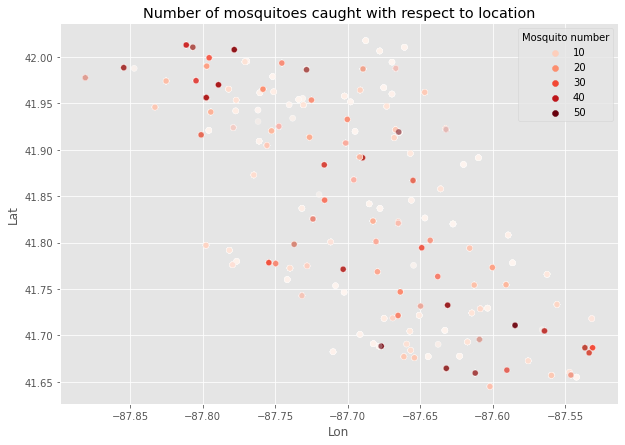

In [36]:
#setting plot figure
plt.figure(figsize=(10, 7))

#creating scatter plot
sns.scatterplot(data=df_linreg, x="Lon", y="Lat", hue="Mosquito number", palette="Reds", alpha=0.5)

#setting title
plt.title("Number of mosquitoes caught with respect to location")

#showing the plot
plt.show()

We can see high number of mosquitoes shown in the top left and bottom right sectors, which means that location may be a valuable predictor for number of mosquitoes caught. Now let's jump into our Linear Regression model

### Verifying assumptions within the model<a id="verifying"></a>

First, let's create our X and y variables. X will contain the independent variables and will hold every column except for `Mosquito number` and `WNV Present`, which we are not going to be using. `Mosquito number` will be our dependent variable contained in under y. We will also drop the `Address Block` column as it is an object type not suited for linear regression and the `Trap` column, which is already present in our dummy variables. Afterwards we will check the shape of both variables to see what we are working with.

In [37]:
# Separating the data into X and y variables

X = df_linreg.drop(columns='Mosquito number').drop(columns="WNV Present").drop(columns="Address Block"). drop(columns="Trap").drop(columns="Date").drop(columns="OVI").drop(columns="CULEX SALINARIUS") #independent variables
y = df_linreg['Mosquito number'] # dependent variable



In [38]:
# Checking the shape of X and y variables

print(f'X has {X.shape[0]} rows and {X.shape[1]} columns.')
print(f'y has {y.shape[0]} rows and 1 column.')

X has 18495 rows and 11 columns.
y has 18495 rows and 1 column.


Let's plot our variables to see if there is a linear relationship and also run a Pearson correlation test to see if there is an interconnection between our variables.

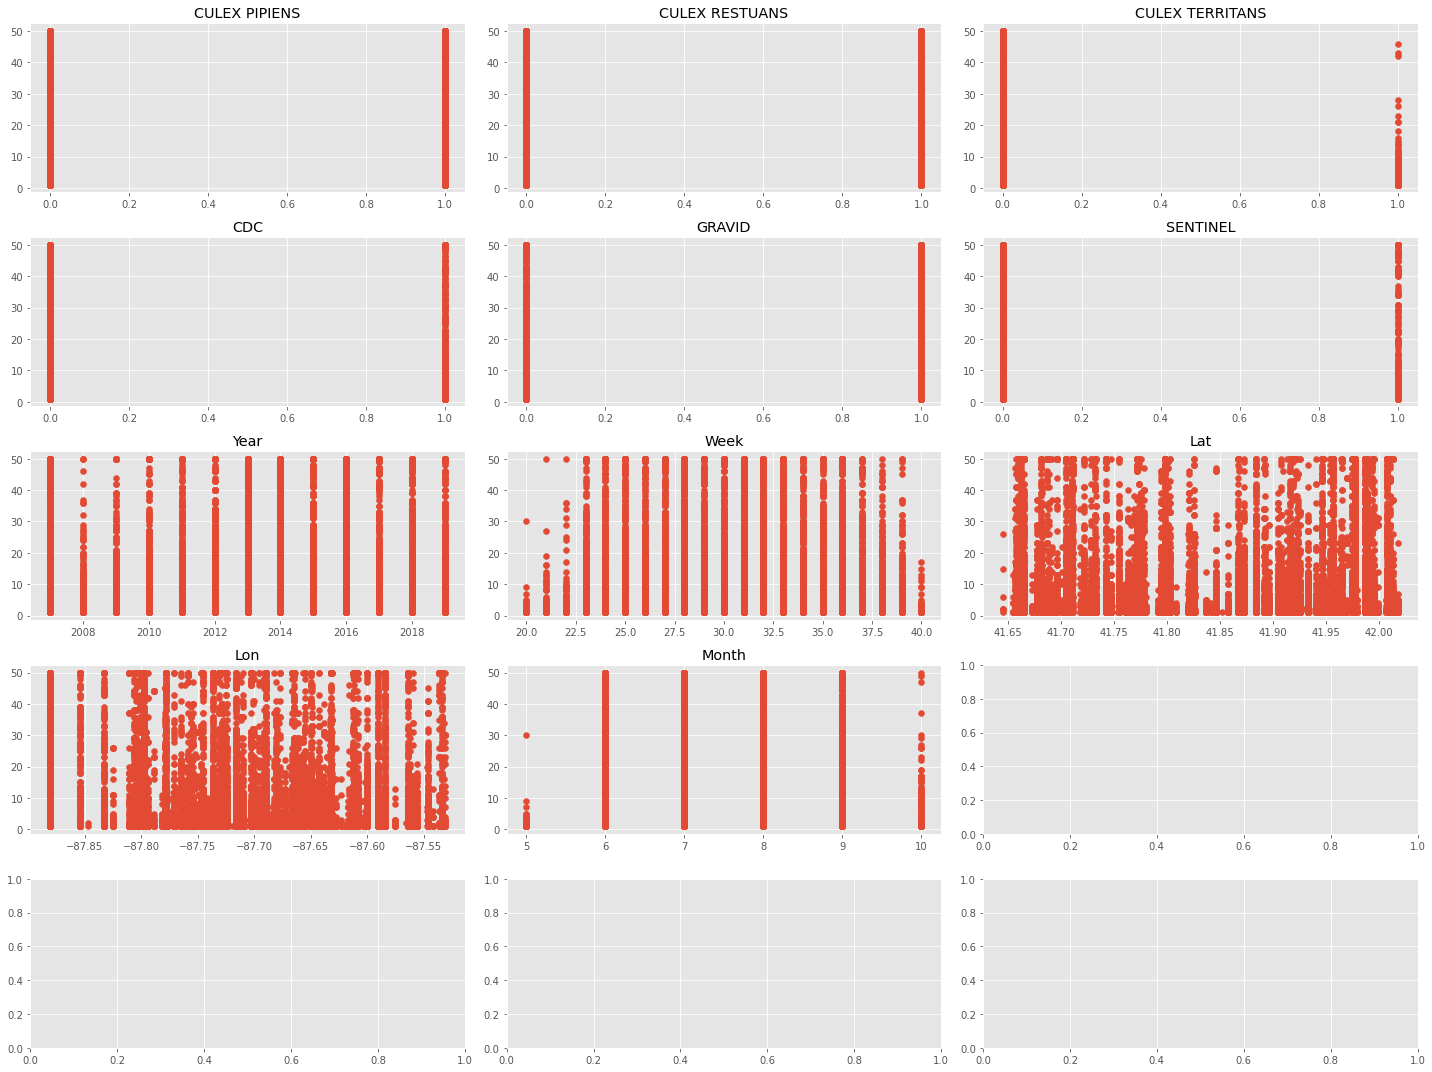

In [39]:
# plotting the relationship between independent and target variables
plt.subplots(5, 3, figsize=(20, 15))

count = 1

for col in X.columns:
    plt.subplot(5, 3, count)
    plt.scatter(X[col], y)
    plt.title(col)
    
    count += 1
    
plt.tight_layout()
plt.show()

In [40]:
#correlation between `Mosquito number` and independent variables

df_linreg.corr()["Mosquito number"].sort_values(ascending=False)

Mosquito number     1.000000
WNV Present         0.408034
Year                0.129326
SENTINEL            0.108575
Lat                 0.096820
CDC                 0.094147
CULEX RESTUANS      0.070999
CULEX PIPIENS       0.014730
OVI                -0.005392
Week               -0.033900
Month              -0.040426
CULEX SALINARIUS   -0.072859
GRAVID             -0.138275
CULEX TERRITANS    -0.150962
Lon                -0.151421
Name: Mosquito number, dtype: float64

We see that most of the variables do not have a strong correlation with `Mosquito number`. `WNV Present` has the strongest correlation but we will not be using that variable. `Year`, `SENTINEL`, `Lat`, and `CDC` columns present a weak positive correlation as well as the `CULEX RESTUANS` mosquito species. They are all between 0.12 and 0.07, which doesn't give us a strong positive relationship. `Lon` and `CULEX TERRITANS` species have the weakest correlations at -0.15. 

Next, let's check the correlations between independent variables. Correlation falls between -1 and 1, with 1 being perfect positive correlation and -1 perfect negative. 

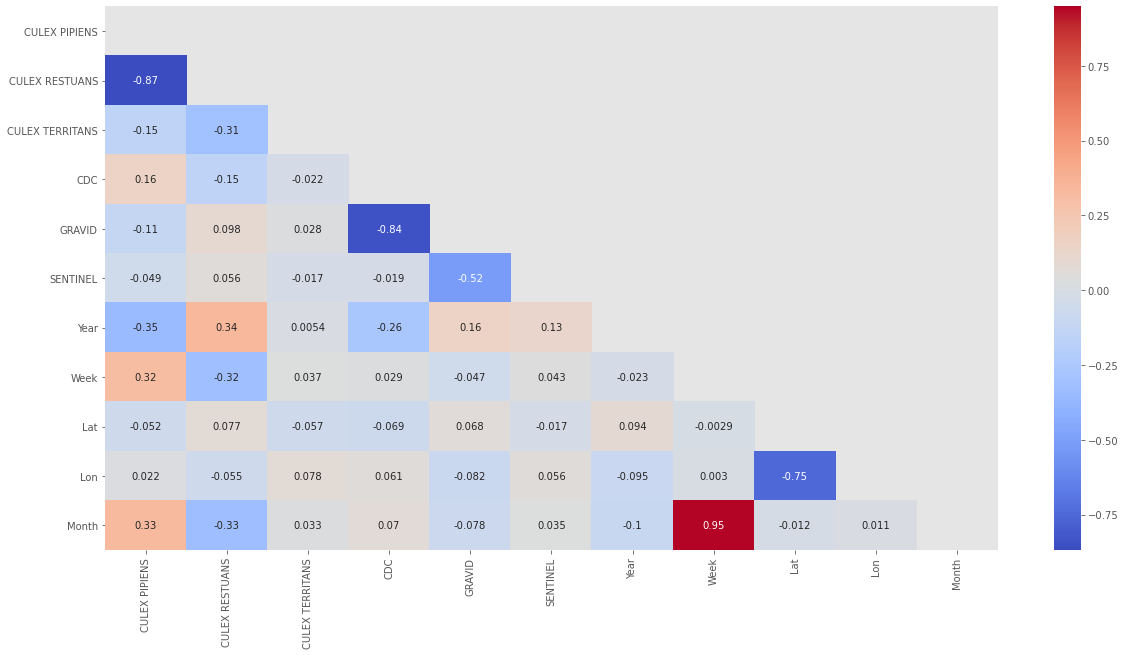

In [41]:
# Creating a heatmap to show correlation between independent variables
plt.figure(figsize=(20, 10))
matrix = np.triu(X.corr())
sns.heatmap(X.corr(), annot=True, mask=matrix, cmap='coolwarm')
plt.show()

When building our model, we don't want too many positive and negative correlations between our variables. The only strong positive correlation we have is between `Week` and `Month` which is not surprising since they are both date columns. We also have some negative correlations, particularly between the `CULEX RESTUANS` and `CULEX PIPIENS` and `GRAVID` and `CDC` columns. `Lon` and `Lat` also have a strong negative correlation. We want to see a lot of values below the 0.5 mark and in this case, the rest columns satisfy that requirement.

### Building a Linear Regression model<a id="building"></a>

Now that we're ready to do our linear regression analysis, let's start by adding our constant, which is the y-intercept:

In [42]:
#adding constant
X = sm.add_constant(X)

X.head()

,const,CULEX PIPIENS,CULEX RESTUANS,CULEX TERRITANS,CDC,GRAVID,SENTINEL,Year,Week,Lat,Lon,Month
0,1.0,0,1,0,0,1,0,2019,39,41.977738,-87.880969,9
1,1.0,0,1,0,0,1,0,2019,39,41.798211,-87.736925,9
2,1.0,0,1,0,0,1,0,2019,39,41.987245,-87.689417,9
3,1.0,0,1,0,0,1,0,2019,39,41.953664,-87.724987,9
4,1.0,0,1,0,0,1,0,2019,39,41.657069,-87.546049,9


Now that we have our constant, first let's start by building a model with all of our variables and follow up with removing the variables which that be impeding on the accuracy of our model. 

In [43]:
# fitting our first linear model
model = linear_model.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Mosquito number   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     171.3
Date:                Tue, 21 Feb 2023   Prob (F-statistic):               0.00
Time:                        01:03:17   Log-Likelihood:                -73448.
No. Observations:               18495   AIC:                         1.469e+05
Df Residuals:                   18483   BIC:                         1.470e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -3023.3656    112.167    -26.954      0.000   -3243.223   -2803.508
CULEX PIPIENS       9.7623      0.874     11.172      0.000       8.050      11.475
CULEX RESTUANS      8.5056      0.867      9.805      0.000       6.805      10.206
CULEX TERRITANS     0.4680      0.958      0.489      0.625      -1.409       2.345
CDC                20.9748     12.855      1.632      0.103      -4.222      46.171
GRAVID              9.9813     12.844      0.777      0.437     -15.195      35.157
SENTINEL           23.0377     12.878      1.789      0.074      -2.205      48.280
Year                0.5333      0.029     18.425      0.000       0.477       0.590
Week               -0.0762      0.072     -1.065      0.287      -0.216       0.064
Lat                -4.8662      1.239     -3.928      0.000      -7.294      -2.438
Lon               -24.5167      1.503    -16.314      0.000     -27.462     -21.571
Month              -0.3356      0.311     -1.080      0.280      -0.945       0.273
==============================================================================
Omnibus:                     4534.845   Durbin-Watson:                   1.551
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8986.296
Skew:                           1.504   Prob(JB):                         0.00
Kurtosis:                       4.618   Cond. No.                     2.40e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.4e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Model Assessment with R<sup>2<sup/>** <br>
 
| Model | Variables                                  | R<sup>2<sup/>    |
|-------|--------------------------------------------|-------|
| 1 | All                                        | 0.093 |
    
The R-suquared value for the first model with all variables present is very low at 0.093. The p-values for `CULEX TERRITANS`, `CDC`, `GRAVID`, `SENTINEL`, `Week`, and `Month` are very high which means that we can remove them for our next model. These variables are not statistically significant for our model.

In [44]:
# dropping the mentioend variables for our next assessment
X_new = X.drop(columns=["CULEX TERRITANS",'SENTINEL', "CDC", "GRAVID", "Week", "Month"])

# fitting our second linear model
model2 = linear_model.OLS(y, X_new).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Mosquito number   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     248.0
Date:                Tue, 21 Feb 2023   Prob (F-statistic):          2.32e-257
Time:                        01:03:17   Log-Likelihood:                -73745.
No. Observations:               18495   AIC:                         1.475e+05
Df Residuals:                   18489   BIC:                         1.475e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -2711.5924    111.463    -24.327      0.000   -2930.071   -2493.114
CULEX PIPIENS      9.5019      0.427     22.231      0.000       8.664      10.340
CULEX RESTUANS     8.4794      0.407     20.854      0.000       7.682       9.276
Year               0.4564      0.028     16.488      0.000       0.402       0.511
Lat               -4.9595      1.257     -3.944      0.000      -7.424      -2.495
Lon              -22.8366      1.522    -15.005      0.000     -25.820     -19.853
==============================================================================
Omnibus:                     4987.400   Durbin-Watson:                   1.539
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10549.164
Skew:                           1.612   Prob(JB):                         0.00
Kurtosis:                       4.816   Cond. No.                     2.34e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.34e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Model Assessment with R<sup>2<sup/>** <br>
    
| Model | Variables                                  | R<sup>2<sup/>    |
|-------|--------------------------------------------|-------|
1 | All                                        | 0.093 |
| 2 | All minus `CULEX TERRITANS`, `CDC`, `Week`, `Month`                      | 0.063 |
    
    
Our R-sqauared drops to 0.063 and the p-vales remain significant. Next, let's try a different approach by using `Year` and `SENTINEL` which had the highest correlation with `Mosquito number`.

In [45]:
# Checking variables with highest correlation with Mosquito number

cal_corr = df_linreg.corr()
cal_corr['Mosquito number'].sort_values()

Lon                -0.151421
CULEX TERRITANS    -0.150962
GRAVID             -0.138275
CULEX SALINARIUS   -0.072859
Month              -0.040426
Week               -0.033900
OVI                -0.005392
CULEX PIPIENS       0.014730
CULEX RESTUANS      0.070999
CDC                 0.094147
Lat                 0.096820
SENTINEL            0.108575
Year                0.129326
WNV Present         0.408034
Mosquito number     1.000000
Name: Mosquito number, dtype: float64

In [46]:
#fitting our third model
model3 = linear_model.OLS(y, X[['const', 'Year', "SENTINEL"]]).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Mosquito number   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     240.3
Date:                Tue, 21 Feb 2023   Prob (F-statistic):          9.77e-104
Time:                        01:03:17   Log-Likelihood:                -74108.
No. Observations:               18495   AIC:                         1.482e+05
Df Residuals:                   18492   BIC:                         1.482e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -843.3740     53.292    -15.826      0.000    -947.831    -738.917
Year           0.4243      0.026     16.027      0.000       0.372       0.476
SENTINEL      11.9218      0.933     12.775      0.000      10.093      13.751
==============================================================================
Omnibus:                     5043.493   Durbin-Watson:                   1.511
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10668.563
Skew:                           1.635   Prob(JB):                         0.00
Kurtosis:                       4.774   Cond. No.                     1.10e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.1e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Model Assessment with R<sup>2<sup/>** <br>
    
| Model | Variables                                  | R<sup>2<sup/>    |
|-------|--------------------------------------------|-------|
1 | All                                        | 0.093 |
| 2 | All minus `CULEX TERRITANS`, `CDC`, `Week`, `Month`                      | 0.063 |
| 3 | `Year` and `SENTINEL`                   | 0.025 |
    
    
When we use only the most correlated variables, `Year` and `SENTINEL`, our R-squared drops segnificantly to 0.025 which is not ideal but our p-values still look good. Next we can add the `Lat` and `Lon` variables to see whether they will have a positive effect on our Linear Regression.

In [47]:
#fitting our fourth model

model4 = linear_model.OLS(y, X[['const', 'Lat', "Lon", "Year", "SENTINEL"]]).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Mosquito number   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     232.3
Date:                Tue, 21 Feb 2023   Prob (F-statistic):          5.72e-195
Time:                        01:03:17   Log-Likelihood:                -73892.
No. Observations:               18495   AIC:                         1.478e+05
Df Residuals:                   18490   BIC:                         1.478e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2783.2901    110.749    -25.132      0.000   -3000.368   -2566.212
Lat           -5.7513      1.267     -4.540      0.000      -8.234      -3.268
Lon          -26.0444      1.536    -16.961      0.000     -29.054     -23.035
Year           0.3727      0.026     14.162      0.000       0.321       0.424
SENTINEL      13.3530      0.925     14.434      0.000      11.540      15.166
==============================================================================
Omnibus:                     5042.938   Durbin-Watson:                   1.517
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10770.111
Skew:                           1.623   Prob(JB):                         0.00
Kurtosis:                       4.855   Cond. No.                     2.31e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.31e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Model Assessment with R<sup>2<sup/>** <br>
    
| Model | Variables                                  | R<sup>2<sup/>    |
|-------|--------------------------------------------|-------|
1 | All                                        | 0.093 |
| 2 | All minus `CULEX TERRITANS`, `CDC`, `Week`, `Month`                      | 0.063 |
| 3 | `Year` and `SENTINEL`                   | 0.025 |
| 4 | `Year`, `SENTINEL`, `Lat` and `Lon`     | 0.048 |
    
The addition of the coordinate variables gives us a slighly higher R-squared value but still not as high as when we started out with all variables. Due to the fact that most of our variables are binary and not conitunous makes it hard to use Linear Regression to make an accurate prediction. 
    
Next, let's run some model diagnostics by checking Residuals and Homoscedasticity.
    

### Model Diagnostics with Residuals and Homoscedasticity<a id="residuals"></a>

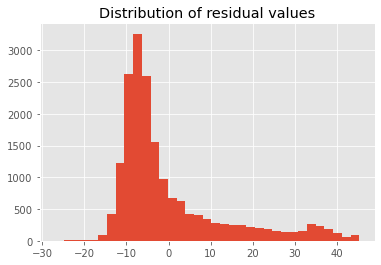

In [48]:
# Plotting the residuals of the model 3.1.2
plt.figure()
plt.hist(model4.resid, bins = 35)
plt.title('Distribution of residual values')
plt.show()

Residuals represent the error of the model and measure how well the model fits the data. Our residuals are right skewed and not normally distributed which we can double check using the Shapiro-Wilk test.

$$ H_0 : \text{Data is normally distributed}  \quad vs. \quad H_1 : \text{Data is not normally distributed} $$

In [49]:
# calculating the shapiro test statisic and its p-value

print("Shapiro-Wilk Test: ", stats.shapiro(model4.resid))


Shapiro-Wilk Test:  ShapiroResult(statistic=0.789718508720398, pvalue=0.0)


/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Since the null hypothesis for Shapiro-Wilk Test is that the data is normally distributed, our p-value of 0 means that we can reject the null and conclude that it's not a normal distribution. Let's further explore with a normal Q-Q plot:

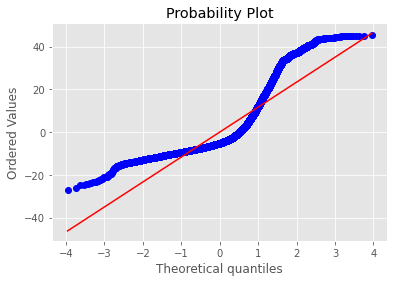

In [50]:
# Normal Q-Q plot

plt.figure()
stats.probplot(model4.resid, dist="norm", plot=plt)
plt.show()

We can definitely see the right skew on the right side of the graph and the deviation from the red line shows that the sample distribution has some outliers and irregularities that are not well captured by the theoretical quintiles. Lastly, let's look at homoscedasticity:

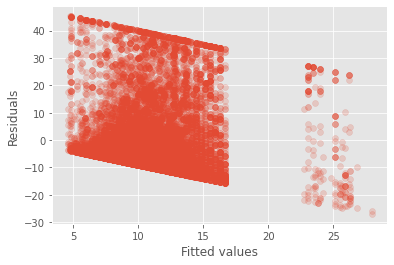

In [51]:
# Plot the residuals and the predicted values
plt.figure()
plt.scatter(model4.fittedvalues, model4.resid, alpha=0.2)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()

The residuals don't look random and follow a downward slope, which suggest heteroscedasticity, where the variance of the errors is not constant across the range of predictor variables. The graph is showing a funnel pattern, which could indicate that the variance is changing across the range of predictor variables. This can lead to biased and inefficient regression coefficient estimates and invalid standard errors.

### Logistic Regression<a id="logistic"></a>

Now we can conduct a logistic regression to show how the independent variables affect the presence of West Nile Virus. Logistic regression is used to determine the relationship between a dependent and one or more independent variables  by estimating the probability of the dependent variable for each value of the independent variables. 

In contrast to linear regression, which is used to predict continuous outcomes, logistic regression is used to predict the probability of a binary outcome, in this case our independent variables can predict the outcome of the `WNV Present` column.

### Preparing for Logistic Regression<a id="preparinglog"></a>

Let's start by seeing the columns that we will be working with, as well as dropping our dependent variable and any duplicate variables.

In [52]:
df_linreg.columns

Index(['CULEX PIPIENS', 'CULEX RESTUANS', 'CULEX SALINARIUS',
       'CULEX TERRITANS', 'CDC', 'GRAVID', 'OVI', 'SENTINEL', 'WNV Present',
       'Year', 'Week', 'Address Block', 'Trap', 'Date', 'Mosquito number',
       'Lat', 'Lon', 'Month'],
      dtype='object')

We can convert the Months into seasons.

In [53]:
#converting months into seasons
df_linreg['Month'] = df_linreg['Month'].astype("string")

#categorizing months by season. june-august = summer, september and october = fall, may = spring.
df_linreg['Month'] = df_linreg['Month'].replace(['8', '7', '6'], 'summer')
df_linreg['Month'] = df_linreg['Month'].replace(['5'], 'spring')
df_linreg['Month'] = df_linreg['Month'].replace(['9', '10'], 'fall')
#creating dummy variables
df_linreg = pd.get_dummies(df_linreg, columns = ['Month'])



In [54]:
#dropping the WNV Present, Trap and Date variables since we already have those categories covered. 
#dropping Address Block because it's an object not suitable for logistic regression
df_linreg = df_linreg.drop(columns=["Trap", "Date", "Address Block"])


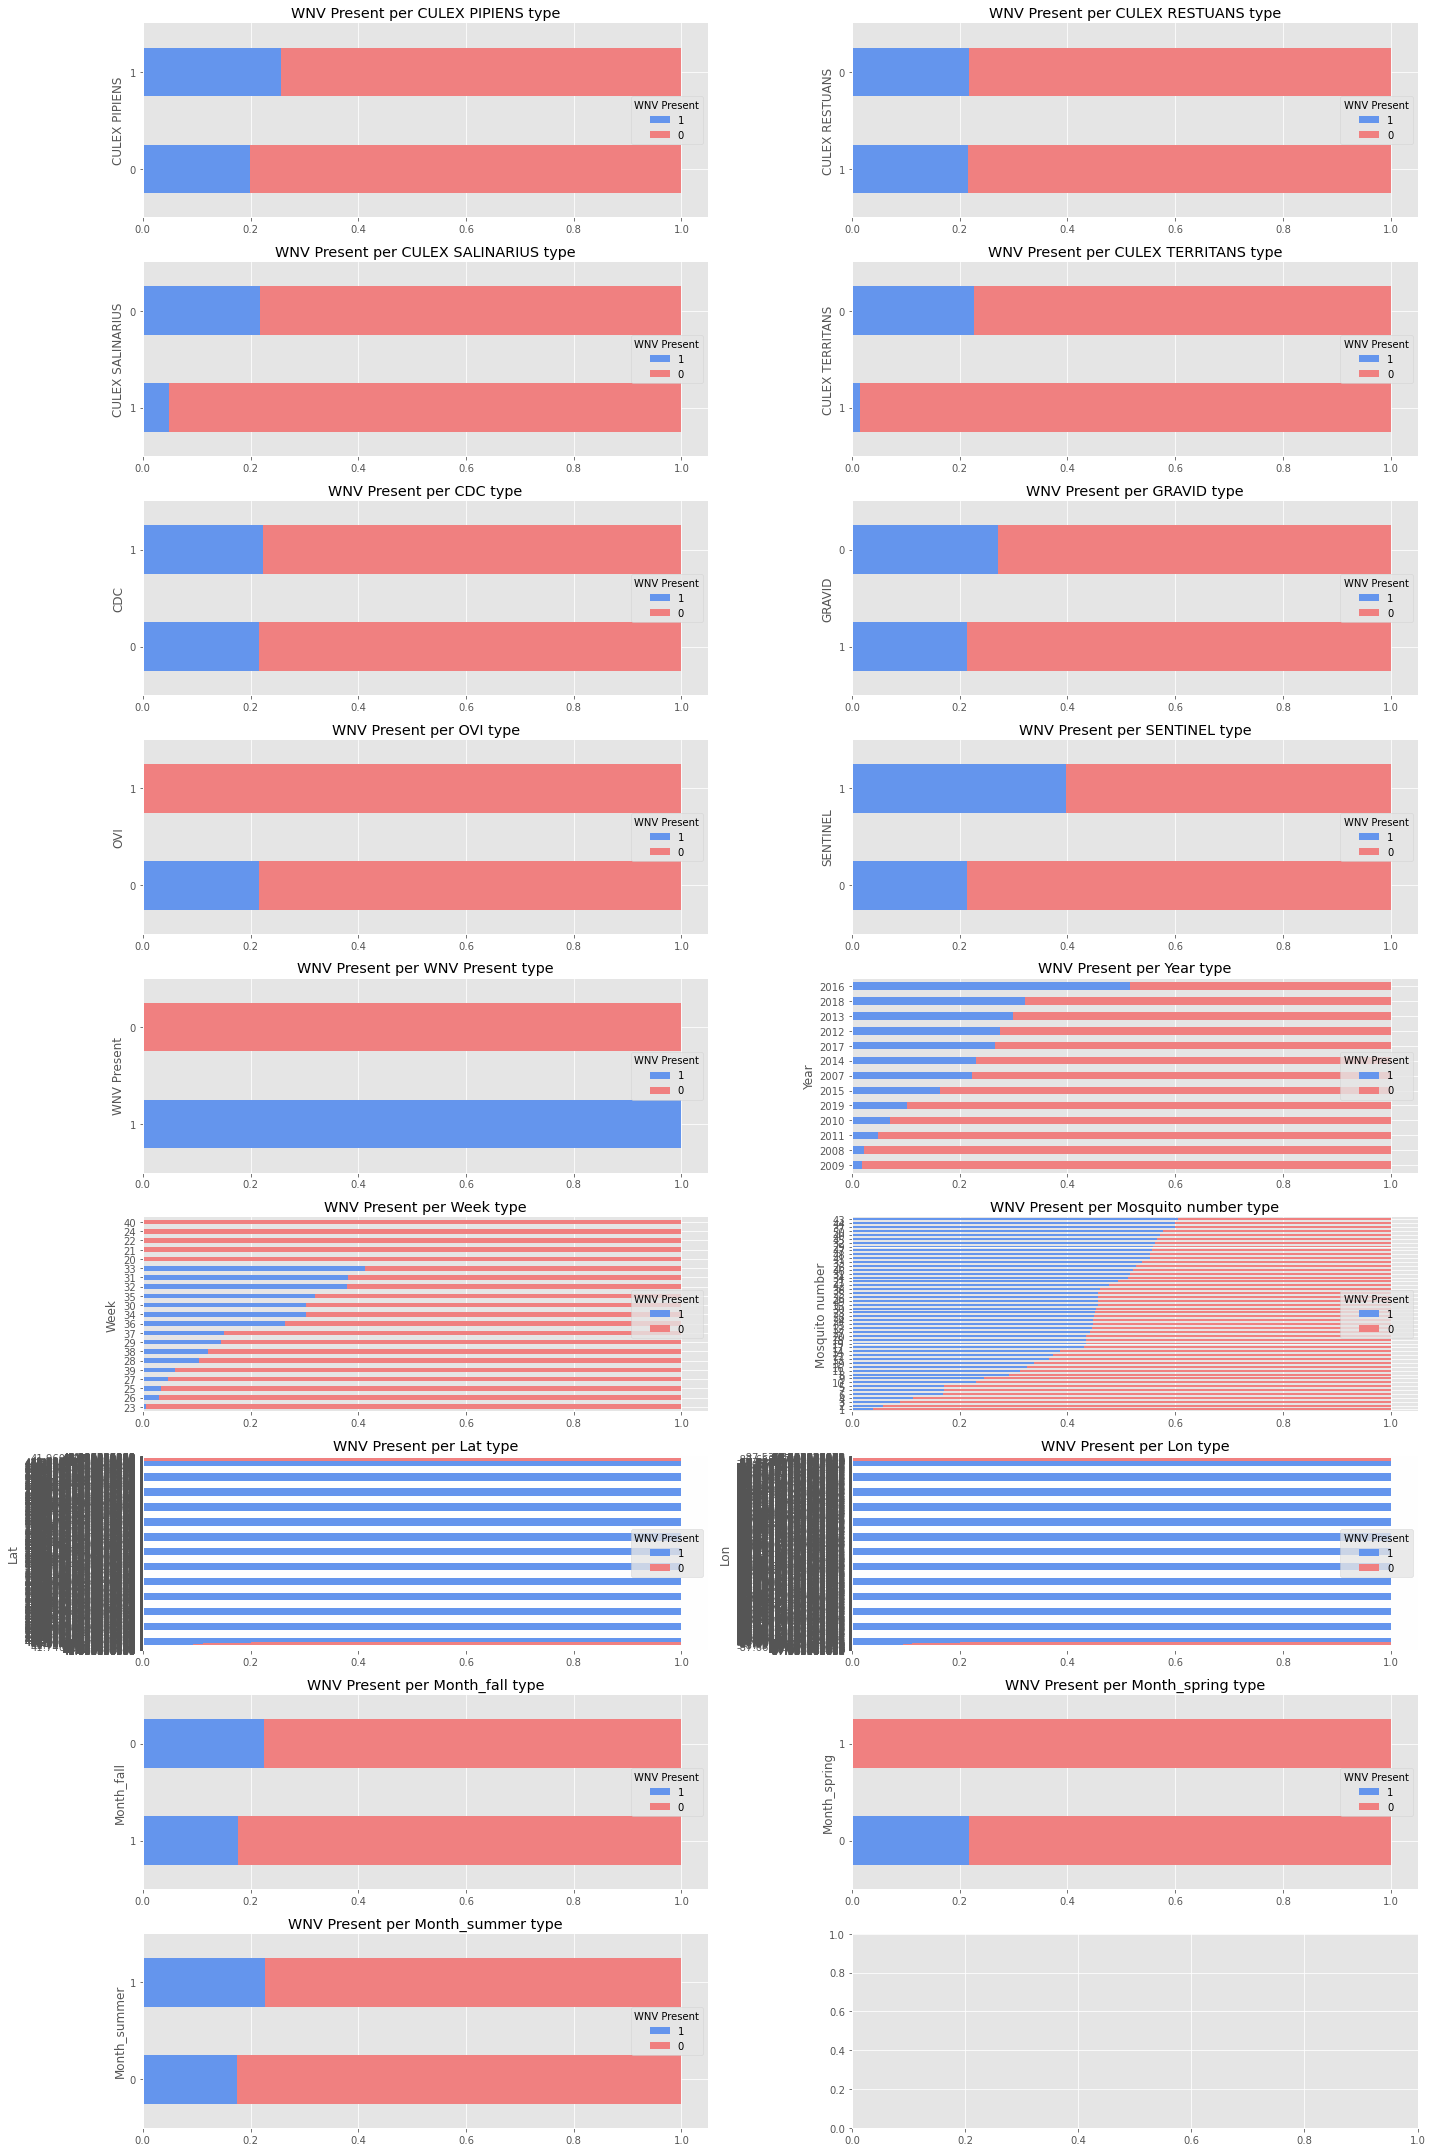

In [67]:
plt.subplots(9, 2, figsize=(20, 30))
slot = 1

#iterating over our columns to create 
for column in df_linreg.columns:
    rate_data = df_linreg.groupby([column, "WNV Present"])["WNV Present"].count() / df_linreg.groupby(column)["WNV Present"].count()
    
    # move plot to next slot
    plt.subplot(9, 2, slot)
    rate_data.unstack()[[1, 0]]\
        .sort_values(1)\
        .plot(kind="barh", stacked=True, color=["cornflowerblue", "lightcoral"], ax=plt.gca()) # need to specify the axis

    plt.title(f"WNV Present per {column} type")
    sns.despine()
   
    # increase slot counter
    slot += 1

plt.tight_layout()
plt.show()

Here's what we can conclude from the plots above:
- Most of the positive cases were in the Summer months
- `SENTINEL` traps captured a lot of positive mosquitoes.
- Many `CULEX PIPIENS` mosquitoes were positive.
- `Mosquito number`'s seem to have more positive values with higher number of mosquitoes caught.


Let's see the new correlation heatmap for our new dummy variables

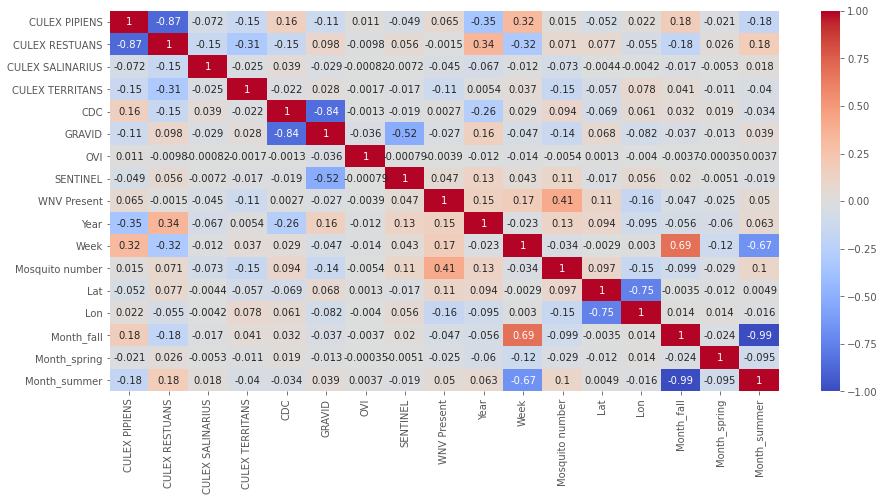

In [56]:
#plotting correlation heatmap
plt.subplots(figsize=(15, 7)) 
sns.heatmap(df_linreg.corr(), annot=True, vmin=-1, vmax=1, cmap="coolwarm")
plt.show()

This looks good, we have a few high correlation values but most of the variables are not correlated with each other.

Now that we have some observable relationships, we are ready to start constructing our logistic regression model.

### Building a Logistic Regression model <a id="buildlog"></a>

In [57]:
#defining our variables. we dropped WNV Present when defining out df_logreg, so lets borrow it from df_inreg 
X = df_linreg.drop(columns="WNV Present") #independent variables
y = df_linreg["WNV Present"] #dependent variable

In [58]:
#setting our constant
X_withconstant = sm.add_constant(X)

#selecting predictors
predictor_columns = ["const", "Mosquito number", "Month_summer", "CULEX RESTUANS", "CULEX TERRITANS", "GRAVID", "SENTINEL"]

#setting up our model
model = sm.Logit(y, X_withconstant[predictor_columns])

#obtaining results
results = model.fit()

results.summary()

Optimization terminated successfully.
         Current function value: inf
         Iterations 8


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1863: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            WNV Present   No. Observations:                18495
Model:                          Logit   Df Residuals:                    18488
Method:                           MLE   Df Model:                            6
Date:                Tue, 21 Feb 2023   Pseudo R-squ.:                     inf
Time:                        01:05:49   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -2.8227      0.132    -21.379      0.000      -3.081      -2.564
Mosquito number     0.0631      0.001     46.871      0.000       0.060       0.066
Month_summer        0.1424      0.053      2.709      0.007       0.039       0.245
CULEX RESTUANS     -0.3630      0.043     -8.418      0.000      -0.447      -0.278
CULEX TERRITANS    -2.4814      0.273     -9.101      0.000      -3.016      -1.947
GRAVID              0.8716      0.127      6.873      0.000       0.623       1.120
SENTINEL            0.9738      0.206      4.725      0.000       0.570       1.378
===================================================================================
"""

In [59]:
#creating prediction model
predicted_probs = results.predict(X_withconstant[predictor_columns])

predicted_WNV = np.where(predicted_probs >= 0.5, 1, 0)

#setting number of correct predictions
number_of_correct_predictions = (predicted_WNV == y).sum()

#testing accuracy
accuracy = number_of_correct_predictions / y.shape[0]

accuracy

0.7947553392808867

The constant coefficient and all variables have 0 p-values which is a positive sign for correlation The constant coefficient is a negative of -2.8 along with the two species of mosquito. Our accuracy is also pretty good at around 79%, however we can remove a few variables and see how things change.


| Model | Predictors | Accuracy | Comments                      |   |
|-------|------------|----------|-------------------------------|---|
| #1    | `Mosquito number`, `Month_summer`, `CULEX RESTUANS`, `CULEX TERRITANS`, `GRAVID`, `SENTINEL`   | 79.47%      | const had negative coeff. |   |
|       |            |          |                               |   |
|       |            |          |                               |   |

In [60]:
predictor_columns = ["const", "Mosquito number", "Month_summer", "CULEX RESTUANS", "Week", "SENTINEL"]

model = sm.Logit(y, X_withconstant[predictor_columns])

results = model.fit()

results.summary()

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1863: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.
         Current function value: inf
         Iterations 7


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            WNV Present   No. Observations:                18495
Model:                          Logit   Df Residuals:                    18489
Method:                           MLE   Df Model:                            5
Date:                Tue, 21 Feb 2023   Pseudo R-squ.:                     inf
Time:                        01:05:49   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             -15.2424      0.352    -43.339      0.000     -15.932     -14.553
Mosquito number     0.0723      0.001     48.631      0.000       0.069       0.075
Month_summer        2.2345      0.074     30.361      0.000       2.090       2.379
CULEX RESTUANS      0.4063      0.046      8.879      0.000       0.317       0.496
Week                0.3439      0.009     38.110      0.000       0.326       0.362
SENTINEL           -0.4600      0.182     -2.521      0.012      -0.818      -0.102
===================================================================================
"""

In [61]:
#creating prediction model
predicted_probs = results.predict(X_withconstant[predictor_columns])

predicted_WNV = np.where(predicted_probs >= 0.5, 1, 0)

#setting number of correct predictions
number_of_correct_predictions = (predicted_WNV == y).sum()

#testing accuracy
accuracy = number_of_correct_predictions / y.shape[0]

accuracy

0.8183833468505002

| Model | Predictors | Accuracy | Comments                      |   |
|-------|------------|----------|-------------------------------|---|
| #1    | `Mosquito number`, `Month_summer`, `CULEX RESTUANS`, `CULEX TERRITANS`, `GRAVID`, `SENTINEL`   | 79.47%      | const had negative coeff. |   |
|  #2     | `Mosquito number`, `Month_summer`, `CULEX RESTUANS`, `Week`, `SENTINEL`           | 81.83%         |  Adding week slightly improved the model


For the next iteration, we've added the `Week` variable and removed `GRAVID` trap type which helped our prediction model go up to 81.83%. It seems that the date variables have a higher effect on positive WNV cases than do trap type. `SENTINEL`'s p-value slightly went up to 0.012

In [62]:
predictor_columns = ["const", "Mosquito number", "Month_summer", "CULEX RESTUANS", "Week", "Lat", "Lon"]

model = sm.Logit(y, X_withconstant[predictor_columns])

results = model.fit()

results.summary()

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1863: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.
         Current function value: inf
         Iterations 8


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            WNV Present   No. Observations:                18495
Model:                          Logit   Df Residuals:                    18488
Method:                           MLE   Df Model:                            6
Date:                Tue, 21 Feb 2023   Pseudo R-squ.:                     inf
Time:                        01:05:49   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            -354.6191     21.928    -16.172      0.000    -397.598    -311.641
Mosquito number     0.0699      0.001     47.111      0.000       0.067       0.073
Month_summer        2.2672      0.074     30.534      0.000       2.122       2.413
CULEX RESTUANS      0.3571      0.046      7.771      0.000       0.267       0.447
Week                0.3486      0.009     38.199      0.000       0.331       0.366
Lat                -0.6811      0.289     -2.354      0.019      -1.248      -0.114
Lon                -4.1923      0.339    -12.366      0.000      -4.857      -3.528
===================================================================================
"""

In [63]:
#creating prediction model
predicted_probs = results.predict(X_withconstant[predictor_columns])

predicted_WNV = np.where(predicted_probs >= 0.5, 1, 0)

#setting number of correct predictions
number_of_correct_predictions = (predicted_WNV == y).sum()

#testing accuracy
accuracy = number_of_correct_predictions / y.shape[0]

accuracy

0.8220600162206002

| Model | Predictors | Accuracy | Comments                      |   |
|-------|------------|----------|-------------------------------|---|
| #1    | `Mosquito number`, `Month_summer`, `CULEX RESTUANS`, `CULEX TERRITANS`, `GRAVID`, `SENTINEL`   | 79.47%      | const had negative coeff. |   |
|  #2     | `Mosquito number`, `Month_summer`, `CULEX RESTUANS`, `Week`, `SENTINEL`           | 81.83%         |  Adding week slightly improved the model
|  #3      | `Mosquito number`, `Month_summer`, `CULEX RESTUANS`, `Week`, `Lat`, `Lon`   |  82.20%     | Improved performance by adding `Lat` and `Lon` and removing the trap type


In our third iteration, we've added the `Lat` and `Lon` vaues and with the location variables included were able to raise the model's prediction accuracy by 1 point to 82.20%.

### Model Evaluation and Summary<a id="eval"></a>

In [64]:
#looking at odds-ratio
np.exp(results.params[1:])

Mosquito number    1.072453
Month_summer       9.652543
CULEX RESTUANS     1.429108
Week               1.417063
Lat                0.506070
Lon                0.015111
dtype: float64

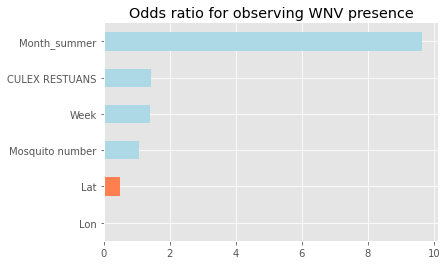

In [65]:
np.exp(results.params[1:]).sort_values().plot(kind="barh", color=np.where(np.exp(results.params[1:]).sort_values() > 1, "lightblue", "coral"))

plt.title("Odds ratio for observing WNV presence")
sns.despine()
plt.show()

It seems that `Month_summer` presents the highest odds-ratio for observing `WNV presence`. These months include June to August, which comprise the majority of the mosquitoes caught which contain the highest rate of infections.  We are almost 10% more likely to observe positive WNV cases during these months. `CULEX RESTUANS` species also plays a role in determining `WNV presence` but the odds-ratio is under 2%. `Week` also has a smaller than 2% odds-ratio which may be connected to the summer months.

## Conclusion<a id="conclusion"></a>


Throughout this analysis, we've created dummy variables, converted columns to binary, computed Chi-Squre tests, Pearson coefficients, as well as developed linear and logistic regression models. The Chi_Square test helped us analyze the relationship between presence of West Nile Virus in certain mosquito species.

We've seen that the R-squared value in the dataset was not friendly towards the linear regression model and with the diagnostics, the residuals and homoscedasticity were not satisifed, thus it was left inconclusive. Most of our variables were binary and not continuous, thus making it harder to run a linear regression.

In the logistic regression model, we came up with a few categories, which helped us predict the prevalence of WNV. The best predictor was `Month_summer`, which raised our odds by almost 10%. This makes sense as most of the mosquitoes were captured in the summer when WNV is also most prevalent. 

It would be intriguing to see if running the regression 10 years from now would lead to any changes in our model. It would also be interesting if we were able to obtain more data that would help make the linear regression model more accurate. 